In [3]:
## Importing the necessary libraries 

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
import squarify
from tqdm import tqdm

import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = pd.read_csv("twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# analysis of mentions and tweets

# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
    hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
    return hashtag_count, mention_count

# Apply the function to each row in the 'text' column
df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))

print('\nDataset shape: ', df.shape)
df.head()


Dataset shape:  (16848, 5)


,Text,Annotation,Label,num_hashtags,num_mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1
4,#mkr No No No No No No,none,0.0,1,0


In [6]:
print('_________Sample tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n_______________________________')

_________Sample tweets_________

Simple tweet:  @ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.


Sexist tweet:  RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy


Racist tweet:  @g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.

_______________________________


In [7]:
## Basic analysis of labels and annotations

print('Label distribution')
print(df.Label.value_counts())
print('-------------------------\n')
print('Annotation distribution')
print(df.Annotation.value_counts())
print('-------------------------\n')
print('Grouping of Annotation with label')
print(df.groupby('Annotation')['Label'].sum())

Label distribution
0.0    11501
1.0     5347
Name: Label, dtype: int64
-------------------------

Annotation distribution
none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64
-------------------------

Grouping of Annotation with label
Annotation
none         0.0
racism    1970.0
sexism    3377.0
Name: Label, dtype: float64


In [8]:
def bully_palette(df,column, positions_to_change: list):
    """
    A function to create grey red palettes according to the inputs
    You just need to pass in the dataframe and the index of labels to be highlighted in red
    """
    palette = ['#96898b']*df[column].nunique()
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)
    
# example
# bully_palette(df,'Label', [0, 1])

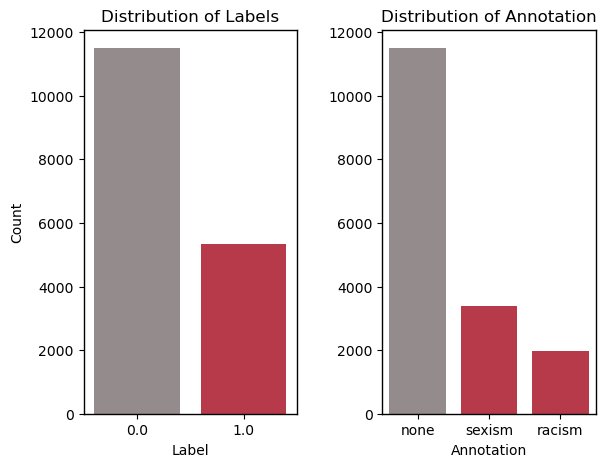

In [9]:
def add_spines(ax, linewidth=1):
    # Add spines to the axes
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

plt.subplot(1, 2, 1)
sns.countplot(x='Label', data=df, palette = bully_palette(df, 'Label', [1]))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
# adding spines using the helper function we declared earlier
add_spines(plt.gca(), linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='Annotation', data=df, palette = bully_palette(df,'Annotation', [1, 2]))
plt.xlabel('Annotation')
plt.ylabel('')
plt.title('Distribution of Annotation')
add_spines(plt.gca(), linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
plt.show()


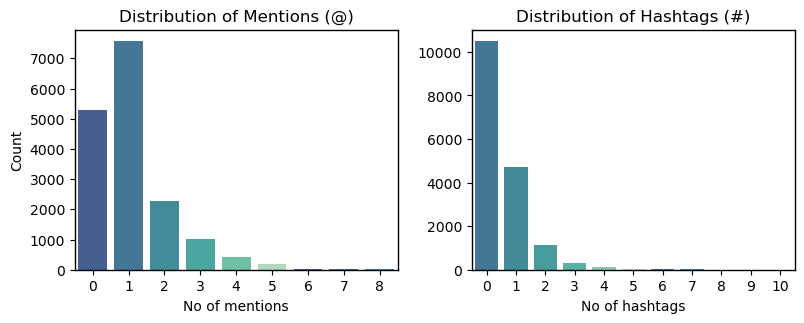

In [10]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=df, palette =  sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions')
plt.ylabel('Count')
plt.title('Distribution of Mentions (@)')
add_spines(plt.gca(), linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=df, palette = sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)')
add_spines(plt.gca(), linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)
plt.show()


<Figure size 600x300 with 0 Axes>

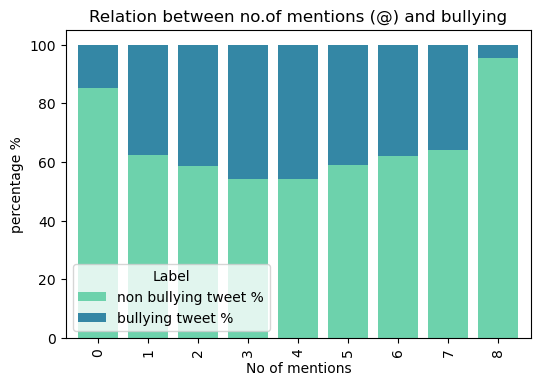

In [11]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(df['num_mentions'], df['Label'])
mention_label_cross['sum'] = mention_label_cross[0.0] + mention_label_cross[1.0]
mention_label_cross['non bullying tweet %'] = mention_label_cross[0.0]/mention_label_cross['sum']*100
mention_label_cross['bullying tweet %'] = mention_label_cross[1.0]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and bullying')
plt.show()

In [12]:
## Using the nltk library to analyze sentiment of each text so that we can correlate it with bullying
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'


df['Sentiment_Label'] = df['Text'].apply(get_sentiment)

df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3,negative
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1,negative
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1,positive
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1,negative
4,#mkr No No No No No No,none,0.0,1,0,negative


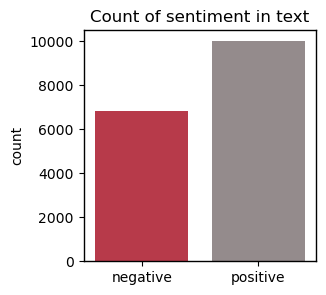

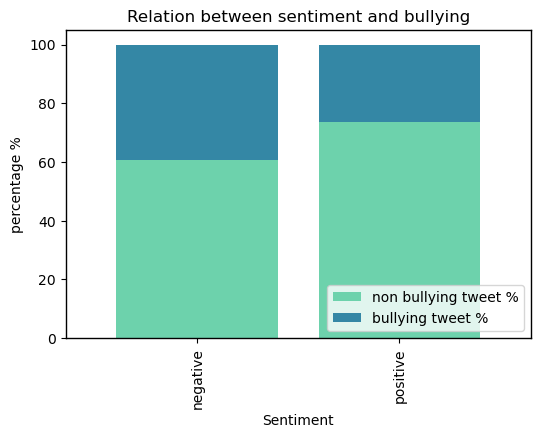

In [13]:
plt.figure(figsize=(3, 3))
df['Sentiment_Label'].value_counts()
sns.countplot(x='Sentiment_Label', data=df, palette = bully_palette(df, 'Sentiment_Label', [0]))
plt.title('Count of sentiment in text')
plt.xlabel('')
add_spines(plt.gca(), linewidth=1)

sent_label_cross = pd.crosstab(df['Sentiment_Label'], df['Label'])
sent_label_cross['sum'] = sent_label_cross[0.0] + sent_label_cross[1.0]
sent_label_cross['non bullying tweet %'] = sent_label_cross[0.0]/sent_label_cross['sum']*100
sent_label_cross['bullying tweet %'] = sent_label_cross[1.0]/sent_label_cross['sum']*100
sent_label_cross = sent_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

ax = sent_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('percentage %')
plt.title('Relation between sentiment and bullying')
ax.legend(loc='lower right')
add_spines(plt.gca(), linewidth=1)

plt.show()

In [14]:
## Extraction of the top ten mentions and hashtags in the dataset

# Function to extract hashtags from a text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)

# Function to extract hashtags from a text
def extract_mentions(text):
    return re.findall(r'@\w+', text)

df['Mentions'] = df['Text'].apply(extract_mentions)

def create_counter_df(df):
    """
    Creates a dataframe that contains the Label and their count.
    Pass the dataframe containing the labels in the form of a list column as an input.
    Example usage:
    1. mentions = create_counter_df(df['Mentions'])
    2. sexist_mentions = create_counter_df(df[df.Annotation=='sexist']["Mentions"])
    """
    # Flatten the list of hashtags and count their occurrences
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)

    # Create a DataFrame from the Counter dictionary
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df
    
mentions_df = create_counter_df(df['Mentions'])
top_10_mentions = mentions_df.head(10)
sexist_mentions = create_counter_df(df[df.Annotation=='sexism']["Mentions"])
top_10_sexist_mentions = sexist_mentions.head(10)
racist_mentions = create_counter_df(df[df.Annotation=='racism']["Mentions"])
top_10_racist_mentions = racist_mentions.head(10)

hashtags_df = create_counter_df(df['Hashtags'])
top_10_hashtags = hashtags_df.head(10)
sexist_hashtags = create_counter_df(df[df.Annotation=='sexism']["Hashtags"])
top_10_sexist_hashtags = sexist_hashtags.head(10)
racist_hashtags = create_counter_df(df[df.Annotation=='racism']["Hashtags"])
top_10_racist_hashtags = racist_hashtags.head(10)

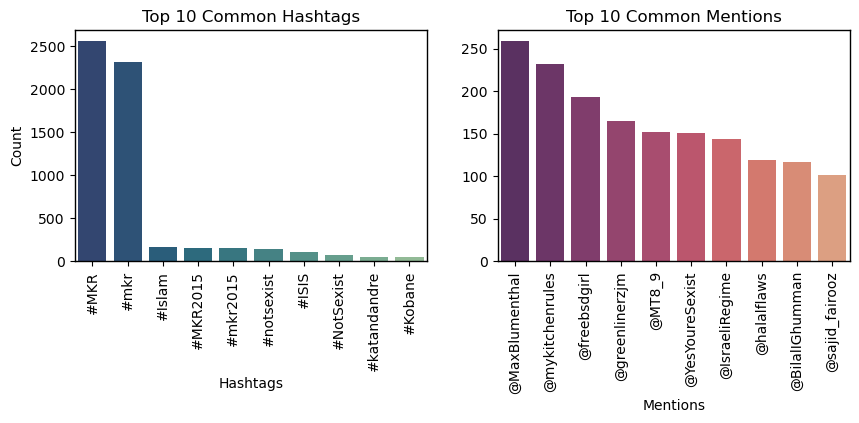

In [15]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.barplot(x='Label', y='Count', data=top_10_hashtags, palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(plt.gca(), linewidth=1)

plt.subplot(122)
sns.barplot(x='Label', y='Count', data=top_10_mentions, palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(plt.gca(), linewidth=1)

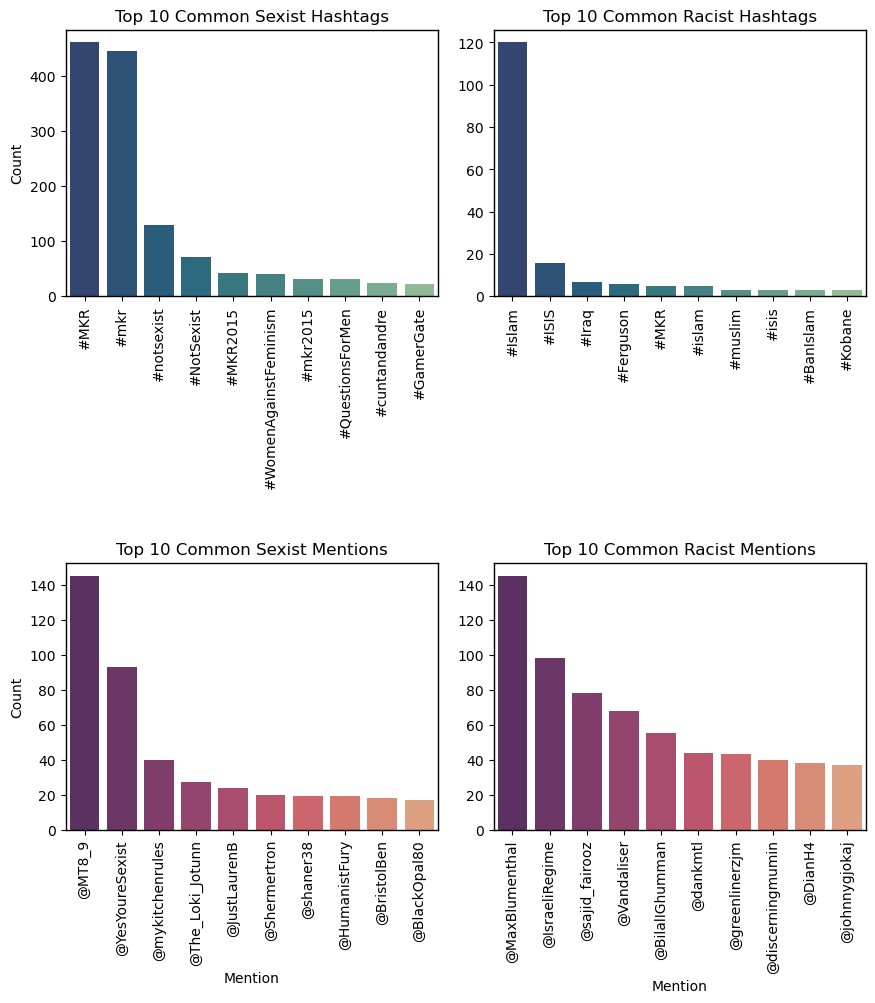

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.barplot(x='Label', y='Count', data=top_10_sexist_hashtags, palette='crest_r')
plt.title('Top 10 Common Sexist Hashtags')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(plt.gca(), linewidth=1)

plt.subplot(222)
sns.barplot(x='Label', y='Count', data=top_10_racist_hashtags, palette='crest_r')
plt.title('Top 10 Common Racist Hashtags')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(plt.gca(), linewidth=1)

plt.subplot(223)
sns.barplot(x='Label', y='Count', data=top_10_sexist_mentions, palette='flare_r')
plt.title('Top 10 Common Sexist Mentions')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(plt.gca(), linewidth=1)

plt.subplot(224)
sns.barplot(x='Label', y='Count', data=top_10_racist_mentions, palette='flare_r')
plt.title('Top 10 Common Racist Mentions')
plt.xlabel('Mention')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(plt.gca(), linewidth=1)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=1)
plt.show()

In [17]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tweet_tokens = nltk.word_tokenize(tweet)
#     tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])
    
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

df['Text'] = df['Text'].apply(clean_tweet)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label,Hashtags,Mentions
0,I read they in contextno change in mean th...,none,0.0,0,3,negative,[],"[@halalflaws, @biebervalue, @greenlinerzjm]"
1,now you idiot claim that people who try to s...,none,0.0,0,1,negative,[],[@ShreyaBafna3]
2,call I sexist but when I go to an auto plac...,sexism,1.0,0,1,positive,[],[@Mooseoftorment]
3,wrong isis follow the example of mohammed an...,racism,1.0,0,1,negative,[],[@g0ssipsquirrelx]
4,no no no no no no,none,0.0,1,0,negative,[#mkr],[]


In [18]:
print('_________Sample clean tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\n\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n\n_______________________________')

_________Sample clean tweets_________


Simple tweet:    now you idiot claim that people who try to stop he from become a terrorist make he a terrorist islamically brain dead


Sexist tweet:     call I sexist but when I go to an auto place i d rather talk to a guy


Racist tweet:    wrong isis follow the example of mohammed and the quran exactly


_______________________________


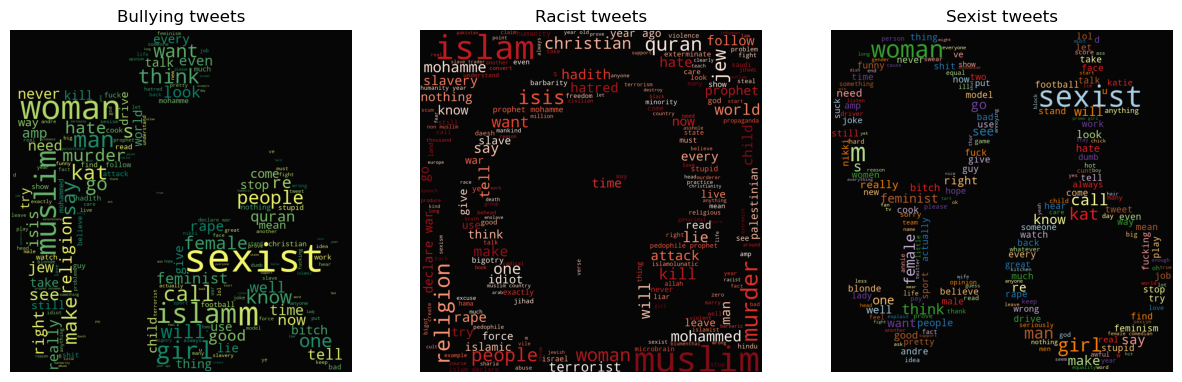

In [19]:
stopword=set(STOPWORDS)
plt.figure(figsize=(15,40))

## Common words in all bullying tweets-----------------------------------------------------------------------------------
plt.subplot(131)
# 1. Get text
bully_text = df[df.Label==1.0]["Text"].values
Text = ''
for text in bully_text:
    Text += text

# 2. Load png image from url and create mask
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/bullying-computer-icons-harassment-clip-art-bully.jpg'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

# 3. Plot wordcloud
wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Bullying tweets')
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)


## Common words in all racist tweets-----------------------------------------------------------------------------------
# Repeat for other plots
plt.subplot(132)
bully_text = df[df.Annotation=='racism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://clipart-library.com/img1/1475559.png'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.title('Racist tweets')
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)


## Common words in all sexist tweets-----------------------------------------------------------------------------------
plt.subplot(133)
bully_text = df[df.Annotation=='sexism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/woman-gender-symbol-male-female-text-line-circle-number-png-clipart.jpg'
response.raise_for_status()
response = requests.get(image_url, stream=True)
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Sexist tweets')
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

In [20]:
# ignore this. I did this for ease of processing when i restart the kernel
# this part gives you the completely preprocessed data right to the point where you just need to oversample and split it

df = pd.read_csv("twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# Adding hashtags and mentions_____________________________________________________________________________________# 
# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
#     hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
#     return hashtag_count, mention_count
    return mention_count

# Apply the function to each row in the 'text' column
df[['num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))
# df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))


# Analyze sentiment of each text____________________________________________________________________________________# 
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'

# Apply the function to each row in the 'Text' column
df['Sentiment_Label'] = df['Text'].apply(get_sentiment)


# Cleaning the tweets_________________________________________________________________________________________________# 
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
      
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

df['Text'] = df['Text'].apply(clean_tweet)
#____________________________________________________________________________________________________________________# 

# One hot encoding of the sentiment category
one_hot_encoded = pd.get_dummies(df['Sentiment_Label'], prefix='sentiment')
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop('Sentiment_Label', axis=1)
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['Text'] = df['Text'].str.strip()

# Step 2: Upsample the data using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

In [21]:
# Step 2: Oversample the data using RandomOverSampler to reduce imbalance between Labels (Bullying and non bullying)
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

In [22]:
# Train Word2Vec Model
sentences = [word_tokenize(text) for text in X_resampled]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # Adjust parameters as needed

# Convert Text to Embeddings
def get_embedding(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
    if len(tokens) > 0:
        # Return the average of word embeddings for the tokens
        return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
    else:
        return None

# Create an array of embeddings for each text
X_resampled = [get_embedding(text) for text in X_resampled]

In [23]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Model Training (Using a RandomForestClassifier as an example)
X_train = np.array(X_train)
X_test = np.array(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.8876331232340795
F1 Score: 0.884002692393987


In [24]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Model Training (Using an ExtraTreesClassifier as an example)
X_train = np.array(X_train)
X_test = np.array(X_test)

#ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Additional Metrics
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8941534449032819
F1 Score: 0.888736577564542
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      2352
         1.0       0.91      0.86      0.89      2249

    accuracy                           0.89      4601
   macro avg       0.90      0.89      0.89      4601
weighted avg       0.90      0.89      0.89      4601

Confusion Matrix:
 [[2169  183]
 [ 304 1945]]


In [25]:
# !pip install -Uqqq pycaret==3.1.0
# from pycaret.classification import *

# Train-Test Split: ensure you are using the word2vec processed data from the above section
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# create a dataset using X_train and y_train
columns = []
dataset = np.column_stack((X_train, y_train))
for i in range(300):
    columns.append(str(i))
columns.append('Label')
auto_df = pd.DataFrame(dataset, columns=columns)

auto_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Label
0,-0.022993,0.344590,0.212836,-0.078825,-0.109943,-0.370423,0.085997,0.565111,-0.084679,-0.237179,...,0.492494,0.334979,0.097081,0.413255,0.637142,-0.027040,-0.187988,0.277205,-0.229238,1.0
1,-0.024544,0.492397,0.330482,-0.055226,-0.234125,-0.327435,-0.188183,0.406420,-0.327241,-0.273478,...,0.656719,0.583729,0.243664,0.566229,1.009184,-0.012794,-0.241937,0.277949,-0.307948,1.0
2,-0.028920,0.184984,0.154309,-0.067865,0.057172,-0.346429,0.309004,0.633378,0.170128,-0.120909,...,0.305551,0.141673,0.046092,0.256938,0.349758,-0.001705,-0.102809,0.249674,-0.111400,1.0
3,-0.036736,0.398241,-0.004505,-0.168000,0.069317,-0.385866,0.119170,0.817469,0.119515,-0.174811,...,0.440505,0.057321,0.126583,0.277612,0.373306,-0.055642,-0.150829,0.138744,-0.343133,1.0
4,-0.021296,0.300226,0.125615,-0.080194,-0.062957,-0.361938,0.150590,0.609604,0.025920,-0.197064,...,0.408907,0.238533,0.091256,0.373180,0.518821,-0.023070,-0.174838,0.211756,-0.243945,0.0


In [26]:
from pycaret.classification import setup
pycaret_automl = setup(data=auto_df, target = 'Label', session_id=42)

,Description,Value
0,Session id,42
1,Target,Label
2,Target type,Binary
3,Original data shape,"(18401, 301)"
4,Transformed data shape,"(18401, 301)"
5,Transformed train set shape,"(12880, 301)"
6,Transformed test set shape,"(5521, 301)"
7,Numeric features,300
8,Preprocess,True
9,Imputation type,simple


In [27]:
from pycaret.classification import compare_models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8429,0.8996,0.7861,0.8886,0.8341,0.6859,0.6907,1.5750
rf,Random Forest Classifier,0.8337,0.8942,0.8010,0.8590,0.8288,0.6675,0.6692,5.1810
xgboost,Extreme Gradient Boosting,0.8134,0.8794,0.8179,0.8123,0.8150,0.6267,0.6268,4.0230
lightgbm,Light Gradient Boosting Machine,0.7871,0.8567,0.7537,0.8101,0.7807,0.5744,0.5760,2.1160
qda,Quadratic Discriminant Analysis,0.7870,0.8505,0.7583,0.8067,0.7816,0.5742,0.5754,0.3790
dt,Decision Tree Classifier,0.7551,0.7559,0.8125,0.7306,0.7693,0.5099,0.5133,2.1220
lda,Linear Discriminant Analysis,0.7476,0.8161,0.7045,0.7732,0.7371,0.4954,0.4976,0.5400
gbc,Gradient Boosting Classifier,0.7266,0.8041,0.6396,0.7773,0.7016,0.4538,0.4613,34.0840
ridge,Ridge Classifier,0.7111,0.0000,0.6487,0.7439,0.6929,0.4226,0.4262,0.0880
knn,K Neighbors Classifier,0.7030,0.7691,0.7001,0.7064,0.7032,0.4059,0.4060,0.9260


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model using the best parameters
best_model = ExtraTreesClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: 0.8985003260160834
F1 Score: 0.8930126002290949
